In [ ]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np

# Data manipulation
import pandas as pd

# Visualization
import seaborn as sns

# Deep Learning
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)

# Scikit-learn preprocessing & evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import class_weight
from tensorflow import keras
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
)
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configuration Dictionary
CONFIG = {
    # Data Loading
    "data_path": "/kaggle/input/earthquake-data/final_earthquake_data_2002_2025.csv",
    "years_to_use": 5,  # Use last N years of data
    # Feature Engineering
    "rare_magtype_threshold": 50,  # Threshold for grouping rare magTypes
    # Model Architecture
    "hidden_layers": [128, 64, 32],
    "dropout_rates": [0.3, 0.3, 0.2],
    "learning_rate": 0.001,
    # Training
    "test_size": 0.2,
    "validation_split": 0.2,
    "batch_size": 2048,
    "epochs": 100,
    # Callbacks
    "early_stopping_patience": 15,
    "reduce_lr_patience": 5,
    "reduce_lr_factor": 0.5,
    "min_lr": 1e-6,
    # Paths
    "model_dir": "models",
}

print("=" * 80)
print("EARTHQUAKE DEPTH CLASSIFICATION - CLEAN IMPLEMENTATION")
print("=" * 80)
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print("=" * 80)

EARTHQUAKE DEPTH CLASSIFICATION - CLEAN IMPLEMENTATION
TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [ ]:
print("\n" + "=" * 80)
print("SECTION 2: DATA LOADING & INITIAL CLEANING")
print("=" * 80)

# Load data
df = pd.read_csv(CONFIG["data_path"])
print(f"✓ Loaded data: {df.shape}")

# Filter by year
if "year" not in df.columns:
    df["year"] = pd.to_datetime(df["Timestamp"]).dt.year

max_year = df["year"].max()
cutoff_year = max_year - CONFIG["years_to_use"]
print(f"✓ Using data from {cutoff_year} to {max_year}")

df = df[df["year"] >= cutoff_year].copy()
print(f"✓ Filtered data: {df.shape}")

# Drop unnecessary columns
cols_to_drop = [
    "id",
    "updated",
    "net",
    "status",
    "locationSource",
    "magSource",
    "place",
    "type",
    "Timestamp",
    "Depth",  # Depth is the target source
]

existing_cols_to_drop = [c for c in cols_to_drop if c in df.columns]
df_clean = df.drop(columns=existing_cols_to_drop)
print(f"✓ Dropped {len(existing_cols_to_drop)} columns")
print(f"✓ Remaining columns: {df_clean.columns.tolist()}")
print(f"✓ Final shape after initial cleaning: {df_clean.shape}")



SECTION 2: DATA LOADING & INITIAL CLEANING
✓ Loaded data: (2921770, 28)
✓ Using data from 2020 to 2025
✓ Filtered data: (878914, 28)
✓ Dropped 10 columns
✓ Remaining columns: ['Latitude', 'Longitude', 'Magnitude', 'magType', 'nst', 'gap', 'rms', 'horizontalError', 'depthError', 'year', 'month', 'day', 'hour', 'dayofweek', 'dayofyear', 'energy', 'magnitude_category', 'depth_category']
✓ Final shape after initial cleaning: (878914, 18)


In [ ]:
# ============================================================================
# SECTION 3: FEATURE ENGINEERING
# ============================================================================

print("\n" + "=" * 80)
print("SECTION 3: FEATURE ENGINEERING")
print("=" * 80)

# ---------------------------------------------------------------------------
# 3.1: Temporal Features (Cyclical Encoding)
# ---------------------------------------------------------------------------
print("\n3.1: Creating Temporal Features with Cyclical Encoding")
print("-" * 80)

# Cyclical encoding for hour (0-23)
df_clean["hour_sin"] = np.sin(2 * np.pi * df_clean["hour"] / 24)
df_clean["hour_cos"] = np.cos(2 * np.pi * df_clean["hour"] / 24)

# Cyclical encoding for month (1-12)
df_clean["month_sin"] = np.sin(2 * np.pi * (df_clean["month"] - 1) / 12)
df_clean["month_cos"] = np.cos(2 * np.pi * (df_clean["month"] - 1) / 12)

# Cyclical encoding for day of week (0-6)
df_clean["dayofweek_sin"] = np.sin(2 * np.pi * df_clean["dayofweek"] / 7)
df_clean["dayofweek_cos"] = np.cos(2 * np.pi * df_clean["dayofweek"] / 7)

# Cyclical encoding for day of year (1-366)
df_clean["dayofyear_sin"] = np.sin(
    2 * np.pi * (df_clean["dayofyear"] - 1) / 366
)
df_clean["dayofyear_cos"] = np.cos(
    2 * np.pi * (df_clean["dayofyear"] - 1) / 366
)

print(
    "✓ Created 8 temporal features (sin/cos for hour, month, dayofweek, dayofyear)"
)

# ---------------------------------------------------------------------------
# 3.2: Geographic & Magnitude Features
# ---------------------------------------------------------------------------
print("\n3.2: Creating Geographic & Magnitude Interaction Features")
print("-" * 80)

# Geographic interaction features
df_clean["lat_lon_product"] = df_clean["Latitude"] * df_clean["Longitude"]
df_clean["lat_squared"] = df_clean["Latitude"] ** 2
df_clean["lon_squared"] = df_clean["Longitude"] ** 2
df_clean["distance_from_origin"] = np.sqrt(
    df_clean["Latitude"] ** 2 + df_clean["Longitude"] ** 2
)

# Log-transform energy (highly skewed distribution)
df_clean["log_energy"] = np.log1p(df_clean["energy"])

# Magnitude polynomial features
df_clean["mag_squared"] = df_clean["Magnitude"] ** 2
df_clean["mag_cubed"] = df_clean["Magnitude"] ** 3

# Interaction: Magnitude * Energy
df_clean["mag_energy_interaction"] = (
    df_clean["Magnitude"] * df_clean["log_energy"]
)

print("✓ Created 9 geographic & magnitude features")

# ---------------------------------------------------------------------------
# 3.3: Missing Value Handling
# ---------------------------------------------------------------------------
print("\n3.3: Handling Missing Values with Indicator Features")
print("-" * 80)

numeric_cols = ["nst", "gap", "rms", "horizontalError", "depthError"]

# Report missing values
print("\nMissing values before processing:")
for col in numeric_cols:
    missing_count = df_clean[col].isna().sum()
    missing_pct = 100 * missing_count / len(df_clean)
    print(f"  {col:20s}: {missing_count:7d} ({missing_pct:5.2f}%)")

# Create indicator features for missing values
for col in numeric_cols:
    df_clean[f"{col}_missing"] = df_clean[col].isna().astype(int)

# Fill missing values with median
fill_values = {col: df_clean[col].median() for col in numeric_cols}
df_clean = df_clean.fillna(value=fill_values)

# Drop any remaining NaN rows
rows_before = len(df_clean)
df_clean = df_clean.dropna()
rows_after = len(df_clean)

print(f"\n✓ Created {len(numeric_cols)} indicator features")
print(f"✓ Filled missing values with median")
print(f"✓ Dropped {rows_before - rows_after} rows with remaining NaN")
print(f"✓ Final shape: {df_clean.shape}")

# ---------------------------------------------------------------------------
# 3.4: Categorical Encoding (magType)
# ---------------------------------------------------------------------------
print("\n3.4: Encoding magType (One-Hot with Rare Grouping)")
print("-" * 80)

# Count distribution
type_counts = df_clean["magType"].value_counts()
print("\nmagType distribution (before grouping):")
print(type_counts.head(10))

# Group rare types
threshold = CONFIG["rare_magtype_threshold"]
rare_types = type_counts[type_counts < threshold].index
print(
    f"\nGrouping rare magTypes (< {threshold}) into 'Other': {list(rare_types)}"
)

df_clean["magType"] = df_clean["magType"].replace(rare_types, "Other")

print("\nmagType distribution (after grouping):")
print(df_clean["magType"].value_counts())

# ---------------------------------------------------------------------------
# 3.5: Remove Redundant Features
# ---------------------------------------------------------------------------
print("\n3.5: Removing Redundant Features")
print("-" * 80)

# Remove magnitude_category (redundant with Magnitude)
if "magnitude_category" in df_clean.columns:
    df_clean = df_clean.drop(columns=["magnitude_category"])
    print("✓ Dropped 'magnitude_category' (redundant with Magnitude)")

# Drop original temporal columns (we have cyclical encoded versions)
temporal_cols_to_drop = [
    "year",
    "month",
    "day",
    "hour",
    "dayofweek",
    "dayofyear",
]
existing_temporal = [c for c in temporal_cols_to_drop if c in df_clean.columns]
if existing_temporal:
    df_clean = df_clean.drop(columns=existing_temporal)
    print(f"✓ Dropped original temporal columns: {existing_temporal}")

print(f"\n✓ Feature Engineering Complete!")
print(f"✓ Total columns: {df_clean.shape[1]}")


SECTION 3: FEATURE ENGINEERING

3.1: Creating Temporal Features with Cyclical Encoding
--------------------------------------------------------------------------------


NameError: name 'np' is not defined


SECTION 4: EXPLORATORY DATA ANALYSIS


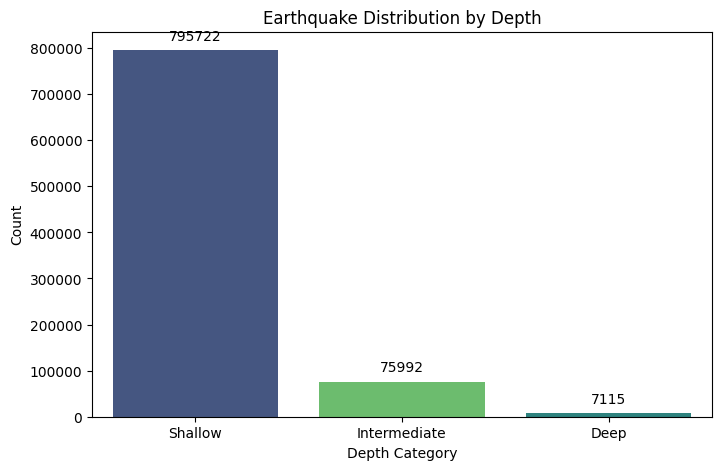


Depth Category Distribution:
depth_category
Shallow         90.543439
Intermediate     8.646961
Deep             0.809600
Name: proportion, dtype: float64


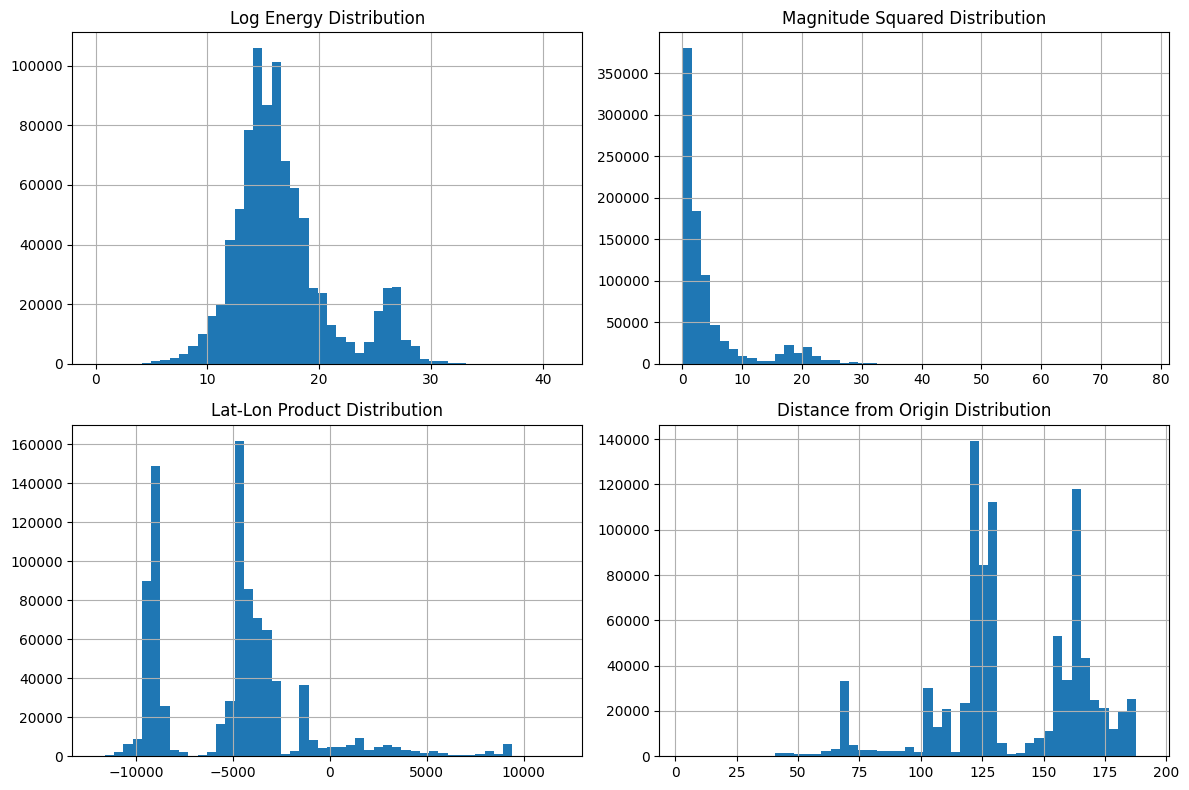

In [ ]:
# ============================================================================
# SECTION 4: EXPLORATORY DATA ANALYSIS
# ============================================================================

print("\n" + "=" * 80)
print("SECTION 4: EXPLORATORY DATA ANALYSIS")
print("=" * 80)

# Map depth_category to English
mapping_en = {"Nông": "Shallow", "Trung bình": "Intermediate", "Sâu": "Deep"}
df_clean["depth_category"] = (
    df_clean["depth_category"]
    .map(mapping_en)
    .fillna(df_clean["depth_category"])
)

# Plot depth distribution
plt.figure(figsize=(8, 5))
ax = sns.countplot(
    x="depth_category",
    data=df_clean,
    order=["Shallow", "Intermediate", "Deep"],
    palette="viridis",
    hue="depth_category",
    legend=False,
)
plt.title("Earthquake Distribution by Depth")
plt.xlabel("Depth Category")
plt.ylabel("Count")

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(
            f"{int(height)}",
            (p.get_x() + p.get_width() / 2.0, height),
            ha="center",
            va="center",
            xytext=(0, 10),
            textcoords="offset points",
        )
plt.show()

# Print percentages
print("\nDepth Category Distribution:")
print(df_clean["depth_category"].value_counts(normalize=True) * 100)

# Visualize new features
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
df_clean["log_energy"].hist(bins=50, ax=axes[0, 0])
axes[0, 0].set_title("Log Energy Distribution")
df_clean["mag_squared"].hist(bins=50, ax=axes[0, 1])
axes[0, 1].set_title("Magnitude Squared Distribution")
df_clean["lat_lon_product"].hist(bins=50, ax=axes[1, 0])
axes[1, 0].set_title("Lat-Lon Product Distribution")
df_clean["distance_from_origin"].hist(bins=50, ax=axes[1, 1])
axes[1, 1].set_title("Distance from Origin Distribution")
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# SECTION 5: FINAL PREPROCESSING & TRAIN/TEST SPLIT
# ============================================================================

print("\n" + "=" * 80)
print("SECTION 5: FINAL PREPROCESSING & TRAIN/TEST SPLIT")
print("=" * 80)

# Define all feature columns (USING ALL ADVANCED FEATURES)
feature_cols = [
    # Geographic features (original + engineered)
    "Latitude",
    "Longitude",
    "lat_lon_product",
    "lat_squared",
    "lon_squared",
    "distance_from_origin",
    # Magnitude features (original + polynomial)
    "Magnitude",
    "mag_squared",
    "mag_cubed",
    # Technical features
    "nst",
    "gap",
    "rms",
    "horizontalError",
    "depthError",
    # Missing indicators
    "nst_missing",
    "gap_missing",
    "rms_missing",
    "horizontalError_missing",
    "depthError_missing",
    # Energy features
    "energy",
    "log_energy",
    "mag_energy_interaction",
    # Temporal features (cyclical encoded)
    "hour_sin",
    "hour_cos",
    "month_sin",
    "month_cos",
    "dayofweek_sin",
    "dayofweek_cos",
    "dayofyear_sin",
    "dayofyear_cos",
]

# One-hot encode magType
df_features = pd.get_dummies(
    df_clean[feature_cols + ["magType"]], columns=["magType"], drop_first=True
)

print(f"\n✓ Total features after one-hot encoding: {df_features.shape[1]}")
print(f"  - Geographic: 6")
print(f"  - Magnitude: 3")
print(f"  - Technical: 5")
print(f"  - Missing indicators: 5")
print(f"  - Energy: 3")
print(f"  - Temporal: 8")
print(
    f"  - magType (one-hot): {len([c for c in df_features.columns if c.startswith('magType_')])}"
)

# Create X, y
X = df_features
le = LabelEncoder()
y = le.fit_transform(df_clean["depth_category"])

print(f"\n✓ Label mapping:")
for i, label in enumerate(le.classes_):
    print(f"  {i}: {label}")

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=CONFIG["test_size"], random_state=42, stratify=y
)

print(f"\n✓ Training set: {X_train.shape}")
print(f"✓ Test set: {X_test.shape}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Features scaled using StandardScaler")

# Compute class weights
class_weights_vals = class_weight.compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
class_weights_dict = dict(enumerate(class_weights_vals))

print(f"\n✓ Class Weights (for handling imbalance):")
for cls, weight in class_weights_dict.items():
    original_label = le.inverse_transform([cls])[0]
    count = np.sum(y_train == cls)
    print(
        f"  Class {cls} ({original_label:12s}): Weight = {weight:6.4f} | Count = {count:6d}"
    )



SECTION 5: FINAL PREPROCESSING & TRAIN/TEST SPLIT

✓ Total features after one-hot encoding: 40
  - Geographic: 6
  - Magnitude: 3
  - Technical: 5
  - Missing indicators: 5
  - Energy: 3
  - Temporal: 8
  - magType (one-hot): 10

✓ Label mapping:
  0: Deep
  1: Intermediate
  2: Shallow

✓ Training set: (703063, 40)
✓ Test set: (175766, 40)

✓ Features scaled using StandardScaler

✓ Class Weights (for handling imbalance):
  Class 0 (Deep        ): Weight = 41.1726 | Count =   5692
  Class 1 (Intermediate): Weight = 3.8549 | Count =  60794
  Class 2 (Shallow     ): Weight = 0.3681 | Count = 636577


In [ ]:
# ============================================================================
# SECTION 6: DEEP LEARNING MODEL
# ============================================================================

print("\n" + "=" * 80)
print("SECTION 6: DEEP LEARNING MODEL BUILDING & TRAINING")
print("=" * 80)

# Convert to categorical for Keras
y_train_categorical = to_categorical(y_train, num_classes=3)
y_test_categorical = to_categorical(y_test, num_classes=3)

print(f"✓ y_train shape: {y_train_categorical.shape}")
print(f"✓ y_test shape: {y_test_categorical.shape}")


def build_mlp_model(input_dim, hidden_layers, dropout_rates, learning_rate):
    """Build Multi-Layer Perceptron model"""
    model = Sequential(name="Earthquake_Depth_MLP")

    # Input + First hidden layer
    model.add(
        Dense(
            hidden_layers[0],
            activation="relu",
            input_shape=(input_dim,),
            name=f"dense_1_{hidden_layers[0]}",
        )
    )
    model.add(Dropout(dropout_rates[0], name="dropout_1"))
    model.add(BatchNormalization(name="batch_norm_1"))

    # Additional hidden layers
    for i, (units, dropout) in enumerate(
        zip(hidden_layers[1:], dropout_rates[1:]), start=2
    ):
        model.add(Dense(units, activation="relu", name=f"dense_{i}_{units}"))
        model.add(Dropout(dropout, name=f"dropout_{i}"))
        model.add(BatchNormalization(name=f"batch_norm_{i}"))

    # Output layer
    model.add(Dense(3, activation="softmax", name="output"))

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


# Build model
input_dim = X_train_scaled.shape[1]
model = build_mlp_model(
    input_dim=input_dim,
    hidden_layers=CONFIG["hidden_layers"],
    dropout_rates=CONFIG["dropout_rates"],
    learning_rate=CONFIG["learning_rate"],
)

print("\n" + "-" * 80)
model.summary()
print("-" * 80)

# Configure callbacks
os.makedirs(CONFIG["model_dir"], exist_ok=True)

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=CONFIG["early_stopping_patience"],
        restore_best_weights=True,
        verbose=1,
        mode="min",
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=CONFIG["reduce_lr_factor"],
        patience=CONFIG["reduce_lr_patience"],
        min_lr=CONFIG["min_lr"],
        verbose=1,
        mode="min",
    ),
    ModelCheckpoint(
        filepath=f"{CONFIG['model_dir']}/best_earthquake_model.h5",
        monitor="val_loss",
        save_best_only=True,
        verbose=1,
        mode="min",
    ),
]

print("\n✓ Callbacks configured:")
print(f"  - EarlyStopping (patience={CONFIG['early_stopping_patience']})")
print(
    f"  - ReduceLROnPlateau (factor={CONFIG['reduce_lr_factor']}, patience={CONFIG['reduce_lr_patience']})"
)
print(f"  - ModelCheckpoint (save best model)")

# Train model
print("\n" + "=" * 80)
print("🚀 STARTING MODEL TRAINING")
print("=" * 80)
print(f"Class weights: {class_weights_dict}")
print("-" * 80)

history = model.fit(
    X_train_scaled,
    y_train_categorical,
    validation_split=CONFIG["validation_split"],
    epochs=CONFIG["epochs"],
    batch_size=CONFIG["batch_size"],
    class_weight=class_weights_dict,
    callbacks=callbacks,
    verbose=1,
)

print("\n✅ Training completed!")


SECTION 6: DEEP LEARNING MODEL BUILDING & TRAINING
✓ y_train shape: (703063, 3)
✓ y_test shape: (175766, 3)

--------------------------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Earthquake_Depth_MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1_128 (Dense)             │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2_64 (Dense)              │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3_32 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_3                    │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,579 (64.76 KB)

 Trainable params: 16,131 (63.01 KB)

 Non-trainable params: 448 (1.75 KB)

--------------------------------------------------------------------------------

✓ Callbacks configured:
  - EarlyStopping (patience=15)
  - ReduceLROnPlateau (factor=0.5, patience=5)
  - ModelCheckpoint (save best model)

🚀 STARTING MODEL TRAINING
Class weights: {0: np.float64(41.17258140079644), 1: np.float64(3.854892478424406), 2: np.float64(0.3681476605867528)}
--------------------------------------------------------------------------------
Epoch 1/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5385 - loss: 0.7994
Epoch 1: val_loss improved from inf to 0.46308, saving model to models/best_earthquake_model.h5


275/275 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.5388 - loss: 0.7988 - val_accuracy: 0.7425 - val_loss: 0.4631 - learning_rate: 0.0010
Epoch 2/100
272/275 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7487 - loss: 0.4427
Epoch 2: val_loss improved from 0.46308 to 0.35015, saving model to models/best_earthquake_model.h5


275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7489 - loss: 0.4424 - val_accuracy: 0.8037 - val_loss: 0.3502 - learning_rate: 0.0010
Epoch 3/100
266/275 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7842 - loss: 0.3839
Epoch 3: val_loss did not improve from 0.35015
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7844 - loss: 0.3835 - val_accuracy: 0.8013 - val_loss: 0.3545 - learning_rate: 0.0010
Epoch 4/100
270/275 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7991 - loss: 0.3540
Epoch 4: val_loss improved from 0.35015 to 0.32713, saving model to models/best_earthquake_model.h5


275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7992 - loss: 0.3539 - val_accuracy: 0.8241 - val_loss: 0.3271 - learning_rate: 0.0010
Epoch 5/100
272/275 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8145 - loss: 0.3309
Epoch 5: val_loss improved from 0.32713 to 0.28810, saving model to models/best_earthquake_model.h5


275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8146 - loss: 0.3308 - val_accuracy: 0.8413 - val_loss: 0.2881 - learning_rate: 0.0010
Epoch 6/100
270/275 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8244 - loss: 0.3170
Epoch 6: val_loss improved from 0.28810 to 0.28790, saving model to models/best_earthquake_model.h5


275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8245 - loss: 0.3169 - val_accuracy: 0.8450 - val_loss: 0.2879 - learning_rate: 0.0010
Epoch 7/100
270/275 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8378 - loss: 0.3019
Epoch 7: val_loss improved from 0.28790 to 0.24715, saving model to models/best_earthquake_model.h5


275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8379 - loss: 0.3018 - val_accuracy: 0.8640 - val_loss: 0.2471 - learning_rate: 0.0010
Epoch 8/100
261/275 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8466 - loss: 0.2895
Epoch 8: val_loss improved from 0.24715 to 0.24426, saving model to models/best_earthquake_model.h5


275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8467 - loss: 0.2894 - val_accuracy: 0.8662 - val_loss: 0.2443 - learning_rate: 0.0010
Epoch 9/100
271/275 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8519 - loss: 0.2850
Epoch 9: val_loss improved from 0.24426 to 0.22622, saving model to models/best_earthquake_model.h5


275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8520 - loss: 0.2849 - val_accuracy: 0.8784 - val_loss: 0.2262 - learning_rate: 0.0010
Epoch 10/100
270/275 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8600 - loss: 0.2719
Epoch 10: val_loss improved from 0.22622 to 0.21507, saving model to models/best_earthquake_model.h5


275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8600 - loss: 0.2718 - val_accuracy: 0.8837 - val_loss: 0.2151 - learning_rate: 0.0010
Epoch 11/100
270/275 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8639 - loss: 0.2662
Epoch 11: val_loss did not improve from 0.21507
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8639 - loss: 0.2661 - val_accuracy: 0.8842 - val_loss: 0.2151 - learning_rate: 0.0010
Epoch 12/100
271/275 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8725 - loss: 0.2576
Epoch 12: val_loss improved from 0.21507 to 0.20718, saving model to models/best_earthquake_model.h5


275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8725 - loss: 0.2575 - val_accuracy: 0.8887 - val_loss: 0.2072 - learning_rate: 0.0010
Epoch 13/100
272/275 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8772 - loss: 0.2504
Epoch 13: val_loss improved from 0.20718 to 0.19909, saving model to models/best_earthquake_model.h5


275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8772 - loss: 0.2504 - val_accuracy: 0.9003 - val_loss: 0.1991 - learning_rate: 0.0010
Epoch 14/100
272/275 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8836 - loss: 0.2450
Epoch 14: val_loss improved from 0.19909 to 0.18086, saving model to models/best_earthquake_model.h5


275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8836 - loss: 0.2450 - val_accuracy: 0.9157 - val_loss: 0.1809 - learning_rate: 0.0010
Epoch 15/100
270/275 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8859 - loss: 0.2387
Epoch 15: val_loss did not improve from 0.18086
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8859 - loss: 0.2387 - val_accuracy: 0.9098 - val_loss: 0.1891 - learning_rate: 0.0010
Epoch 16/100
271/275 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8885 - loss: 0.2342
Epoch 16: val_loss improved from 0.18086 to 0.16714, saving model to models/best_earthquake_model.h5


275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8885 - loss: 0.2342 - val_accuracy: 0.9211 - val_loss: 0.1671 - learning_rate: 0.0010
Epoch 17/100
273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8894 - loss: 0.2324
Epoch 17: val_loss did not improve from 0.16714
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8895 - loss: 0.2324 - val_accuracy: 0.9168 - val_loss: 0.1741 - learning_rate: 0.0010
Epoch 18/100
271/275 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8927 - loss: 0.2248
Epoch 18: val_loss did not improve from 0.16714
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8927 - loss: 0.2248 - val_accuracy: 0.9169 - val_loss: 0.1790 - learning_rate: 0.0010
Epoch 19/100
271/275 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8945 - loss: 0.2251
Epoch 19: val_loss did not improve from 0.16714
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8945 - loss: 0.2251 - val_accuracy: 0.9121 - val_loss: 0.1915 - learning_rate: 0.0010
Epoch 20/100
272/275 ━━━━━━━

275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8967 - loss: 0.2200 - val_accuracy: 0.9226 - val_loss: 0.1645 - learning_rate: 0.0010
Epoch 22/100
271/275 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8988 - loss: 0.2211
Epoch 22: val_loss did not improve from 0.16452
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8988 - loss: 0.2211 - val_accuracy: 0.9197 - val_loss: 0.1756 - learning_rate: 0.0010
Epoch 23/100
272/275 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9003 - loss: 0.2169
Epoch 23: val_loss did not improve from 0.16452
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9003 - loss: 0.2169 - val_accuracy: 0.9152 - val_loss: 0.1805 - learning_rate: 0.0010
Epoch 24/100
271/275 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8999 - loss: 0.2137
Epoch 24: val_loss did not improve from 0.16452
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8999 - loss: 0.2137 - val_accuracy: 0.9104 - val_loss: 0.1930 - learning_rate: 0.0010
Epoch 25/100
269/275 ━━━━━━━

275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9061 - loss: 0.2034 - val_accuracy: 0.9237 - val_loss: 0.1596 - learning_rate: 5.0000e-04
Epoch 28/100
271/275 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9088 - loss: 0.2007
Epoch 28: val_loss did not improve from 0.15959
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9088 - loss: 0.2007 - val_accuracy: 0.9175 - val_loss: 0.1683 - learning_rate: 5.0000e-04
Epoch 29/100
272/275 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9083 - loss: 0.2000
Epoch 29: val_loss did not improve from 0.15959
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9083 - loss: 0.2000 - val_accuracy: 0.9210 - val_loss: 0.1706 - learning_rate: 5.0000e-04
Epoch 30/100
271/275 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9091 - loss: 0.1979
Epoch 30: val_loss did not improve from 0.15959
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9091 - loss: 0.1979 - val_accuracy: 0.9142 - val_loss: 0.1856 - learning_rate: 5.0000e-04
Epoch 31/100

275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9132 - loss: 0.1885 - val_accuracy: 0.9274 - val_loss: 0.1571 - learning_rate: 2.5000e-04
Epoch 36/100
272/275 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9134 - loss: 0.1887
Epoch 36: val_loss did not improve from 0.15710
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9134 - loss: 0.1887 - val_accuracy: 0.9199 - val_loss: 0.1675 - learning_rate: 2.5000e-04
Epoch 37/100
273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9135 - loss: 0.1869
Epoch 37: val_loss did not improve from 0.15710
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9135 - loss: 0.1869 - val_accuracy: 0.9206 - val_loss: 0.1699 - learning_rate: 2.5000e-04
Epoch 38/100
272/275 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9138 - loss: 0.1860
Epoch 38: val_loss did not improve from 0.15710
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9138 - loss: 0.1860 - val_accuracy: 0.9242 - val_loss: 0.1617 - learning_rate: 2.5000e-04
Epoch 39/100

275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9151 - loss: 0.1833 - val_accuracy: 0.9281 - val_loss: 0.1541 - learning_rate: 1.2500e-04
Epoch 42/100
272/275 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9162 - loss: 0.1804
Epoch 42: val_loss did not improve from 0.15405
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9162 - loss: 0.1804 - val_accuracy: 0.9270 - val_loss: 0.1571 - learning_rate: 1.2500e-04
Epoch 43/100
272/275 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9171 - loss: 0.1796
Epoch 43: val_loss did not improve from 0.15405
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9171 - loss: 0.1796 - val_accuracy: 0.9243 - val_loss: 0.1629 - learning_rate: 1.2500e-04
Epoch 44/100
267/275 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9154 - loss: 0.1812
Epoch 44: val_loss did not improve from 0.15405
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9154 - loss: 0.1812 - val_accuracy: 0.9252 - val_loss: 0.1594 - learning_rate: 1.2500e-04
Epoch 45/100


SECTION 7: MODEL EVALUATION


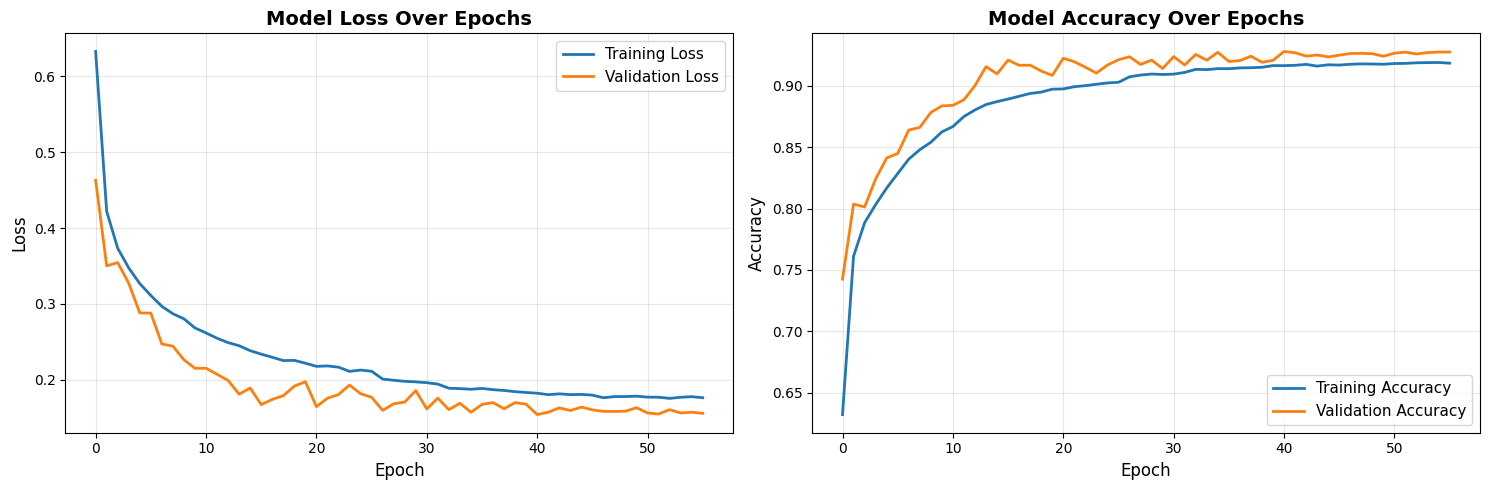


🔍 Evaluating on Test Set...
--------------------------------------------------------------------------------

✅ Test Accuracy: 0.9284 (92.84%)


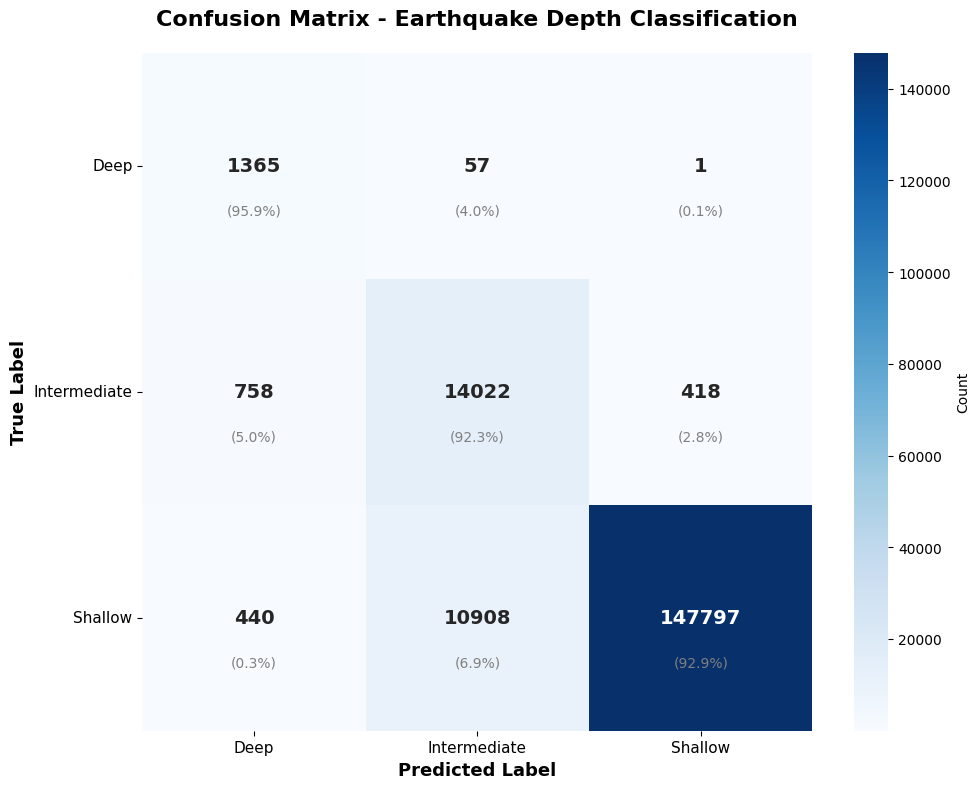


📋 DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Deep     0.5326    0.9592    0.6849      1423
Intermediate     0.5612    0.9226    0.6979     15198
     Shallow     0.9972    0.9287    0.9617    159145

    accuracy                         0.9284    175766
   macro avg     0.6970    0.9369    0.7815    175766
weighted avg     0.9557    0.9284    0.9367    175766



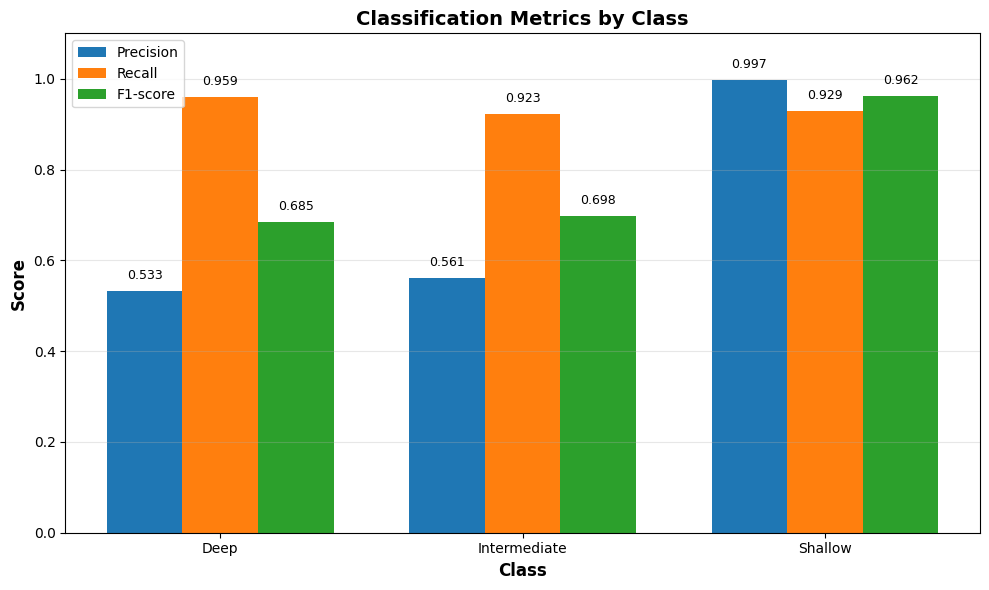


⭐ PRIORITY METRIC: RECALL FOR SHALLOW CLASS
Recall (Shallow): 0.9287 (92.87%)
Target: ≥ 95%
❌ Below target by 2.13%


In [ ]:
# ============================================================================
# SECTION 7: MODEL EVALUATION
# ============================================================================

print("\n" + "=" * 80)
print("SECTION 7: MODEL EVALUATION")
print("=" * 80)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history.history["loss"], label="Training Loss", linewidth=2)
axes[0].plot(history.history["val_loss"], label="Validation Loss", linewidth=2)
axes[0].set_title("Model Loss Over Epochs", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Epoch", fontsize=12)
axes[0].set_ylabel("Loss", fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(
    history.history["accuracy"], label="Training Accuracy", linewidth=2
)
axes[1].plot(
    history.history["val_accuracy"], label="Validation Accuracy", linewidth=2
)
axes[1].set_title("Model Accuracy Over Epochs", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Epoch", fontsize=12)
axes[1].set_ylabel("Accuracy", fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Evaluate on test set
print("\n🔍 Evaluating on Test Set...")
print("-" * 80)

y_pred_proba = model.predict(X_test_scaled, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

test_accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")


# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plot confusion matrix with annotations"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        cbar_kws={"label": "Count"},
        annot_kws={"size": 14, "weight": "bold"},
    )

    plt.title(
        "Confusion Matrix - Earthquake Depth Classification",
        fontsize=16,
        fontweight="bold",
        pad=20,
    )
    plt.xlabel("Predicted Label", fontsize=13, fontweight="bold")
    plt.ylabel("True Label", fontsize=13, fontweight="bold")
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11, rotation=0)

    # Add percentages
    cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j + 0.5,
                i + 0.7,
                f"({cm_percent[i, j]:.1f}%)",
                ha="center",
                va="center",
                fontsize=10,
                color="gray",
            )

    plt.tight_layout()
    plt.show()

    return cm


class_names = ["Deep", "Intermediate", "Shallow"]
cm = plot_confusion_matrix(y_test, y_pred, class_names)

# Classification Report
print("\n" + "=" * 80)
print("📋 DETAILED CLASSIFICATION REPORT")
print("=" * 80)

report = classification_report(
    y_test, y_pred, target_names=class_names, digits=4
)
print(report)

report_dict = classification_report(
    y_test, y_pred, target_names=class_names, output_dict=True
)

# Visualize metrics
fig, ax = plt.subplots(figsize=(10, 6))
metrics = ["precision", "recall", "f1-score"]
x = np.arange(len(class_names))
width = 0.25

for i, metric in enumerate(metrics):
    values = [report_dict[class_name][metric] for class_name in class_names]
    ax.bar(x + i * width, values, width, label=metric.capitalize())

ax.set_xlabel("Class", fontsize=12, fontweight="bold")
ax.set_ylabel("Score", fontsize=12, fontweight="bold")
ax.set_title("Classification Metrics by Class", fontsize=14, fontweight="bold")
ax.set_xticks(x + width)
ax.set_xticklabels(class_names)
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(axis="y", alpha=0.3)

for i, metric in enumerate(metrics):
    values = [report_dict[class_name][metric] for class_name in class_names]
    for j, v in enumerate(values):
        ax.text(
            j + i * width,
            v + 0.02,
            f"{v:.3f}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

plt.tight_layout()
plt.show()

# Priority Metric: Shallow Recall
shallow_class_idx = 2
recall_shallow = recall_score(
    y_test, y_pred, labels=[shallow_class_idx], average=None
)[0]

print("\n" + "=" * 80)
print("⭐ PRIORITY METRIC: RECALL FOR SHALLOW CLASS")
print("=" * 80)
print(f"Recall (Shallow): {recall_shallow:.4f} ({recall_shallow*100:.2f}%)")
print(f"Target: ≥ 95%")
if recall_shallow >= 0.95:
    print("✅ TARGET ACHIEVED!")
else:
    print(f"❌ Below target by {(0.95-recall_shallow)*100:.2f}%")
print("=" * 80)

In [ ]:
# ============================================================================
# SECTION 8: SAVE ARTIFACTS
# ============================================================================

print("\n" + "=" * 80)
print("SECTION 8: SAVING MODEL & ARTIFACTS")
print("=" * 80)

# Save model
model.save(f"{CONFIG['model_dir']}/final_earthquake_model.h5")
print(f"💾 Model saved to: {CONFIG['model_dir']}/final_earthquake_model.h5")

# Save scaler
with open(f"{CONFIG['model_dir']}/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
print(f"💾 Scaler saved to: {CONFIG['model_dir']}/scaler.pkl")

# Save label encoder
with open(f"{CONFIG['model_dir']}/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)
print(f"💾 Label encoder saved to: {CONFIG['model_dir']}/label_encoder.pkl")

print("\n✅ All artifacts saved successfully!")
print("=" * 80)


SECTION 8: SAVING MODEL & ARTIFACTS
💾 Model saved to: models/final_earthquake_model.h5
💾 Scaler saved to: models/scaler.pkl
💾 Label encoder saved to: models/label_encoder.pkl

✅ All artifacts saved successfully!


In [ ]:
# ============================================================================
# SECTION 9: PREDICTION FUNCTION (FOR FUTURE USE)
# ============================================================================


def predict_earthquake_depth(features, model, scaler, label_encoder):
    """
    Predict earthquake depth category for new data

    Args:
        features: DataFrame or array of features (shape: [n_samples, n_features])
        model: Trained Keras model
        scaler: Fitted StandardScaler
        label_encoder: Fitted LabelEncoder

    Returns:
        predictions: Array of predicted class names
        probabilities: Array of prediction probabilities
    """
    features_scaled = scaler.transform(features)
    proba = model.predict(features_scaled, verbose=0)
    pred_classes = np.argmax(proba, axis=1)
    pred_names = label_encoder.inverse_transform(pred_classes)

    return pred_names, proba


# Example usage
print("\n" + "=" * 80)
print("📍 EXAMPLE PREDICTIONS")
print("=" * 80)

sample_features = X_test.iloc[:5]
sample_true_labels = le.inverse_transform(y_test[:5])

predictions, probabilities = predict_earthquake_depth(
    sample_features, model, scaler, le
)

for i in range(5):
    print(f"\nSample {i+1}:")
    print(f"  True Label:      {sample_true_labels[i]}")
    print(f"  Predicted Label: {predictions[i]}")
    print(f"  Probabilities:")
    for j, class_name in enumerate(["Deep", "Intermediate", "Shallow"]):
        print(f"    {class_name}: {probabilities[i][j]*100:.2f}%")
    status = (
        "✅ Correct"
        if predictions[i] == sample_true_labels[i]
        else "❌ Incorrect"
    )
    print(f"  {status}")

print("\n" + "=" * 80)
print("✅ PIPELINE COMPLETED SUCCESSFULLY!")
print("=" * 80)


📍 EXAMPLE PREDICTIONS

Sample 1:
  True Label:      Shallow
  Predicted Label: Shallow
  Probabilities:
    Deep: 0.04%
    Intermediate: 0.46%
    Shallow: 99.50%
  ✅ Correct

Sample 2:
  True Label:      Shallow
  Predicted Label: Shallow
  Probabilities:
    Deep: 0.00%
    Intermediate: 0.02%
    Shallow: 99.97%
  ✅ Correct

Sample 3:
  True Label:      Shallow
  Predicted Label: Shallow
  Probabilities:
    Deep: 0.00%
    Intermediate: 0.00%
    Shallow: 100.00%
  ✅ Correct

Sample 4:
  True Label:      Shallow
  Predicted Label: Intermediate
  Probabilities:
    Deep: 0.01%
    Intermediate: 77.29%
    Shallow: 22.70%
  ❌ Incorrect

Sample 5:
  True Label:      Shallow
  Predicted Label: Shallow
  Probabilities:
    Deep: 0.00%
    Intermediate: 0.00%
    Shallow: 100.00%
  ✅ Correct

✅ PIPELINE COMPLETED SUCCESSFULLY!
